In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve , generate_binary_structure

In [3]:
N=30

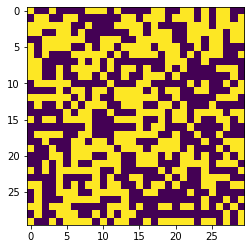

In [4]:
def create_configuration(N):
    init_state = 2.0*np.random.randint(0,2, size=(N,N)) - 1
    return init_state

initial_state = create_configuration(N)
type(initial_state)
plt.imshow(initial_state) 

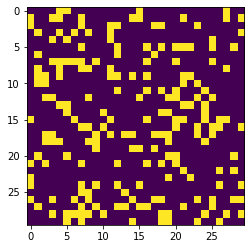

In [5]:
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1
plt.imshow(lattice_n)

In [6]:
def total_energy(lattice):
    kernel = generate_binary_structure(2,1)
    kernel[1][1] = False
    arr = -lattice*convolve(lattice, kernel, mode='constant', cval=0)
    return arr.sum()

total_energy(initial_state)

-72.0

In [7]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nogil=True)
#@numba.njit()
def metropolis(spin_arr, n_iter, BJ, energy):
    # spin_arr = spin_arr.copy()
    net_spins = np.zeros(n_iter-1)
    net_energy = np.zeros(n_iter-1)
    for n in range(0, n_iter-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]

        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]

        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
       
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0) and (np.exp(-BJ*dE) > np.random.random()):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[n] = spin_arr.sum()
        net_energy[n] = energy
            
    return net_spins, net_energy

In [8]:
spins, energies = metropolis(initial_state, 2000000, 0.8, total_energy(initial_state))

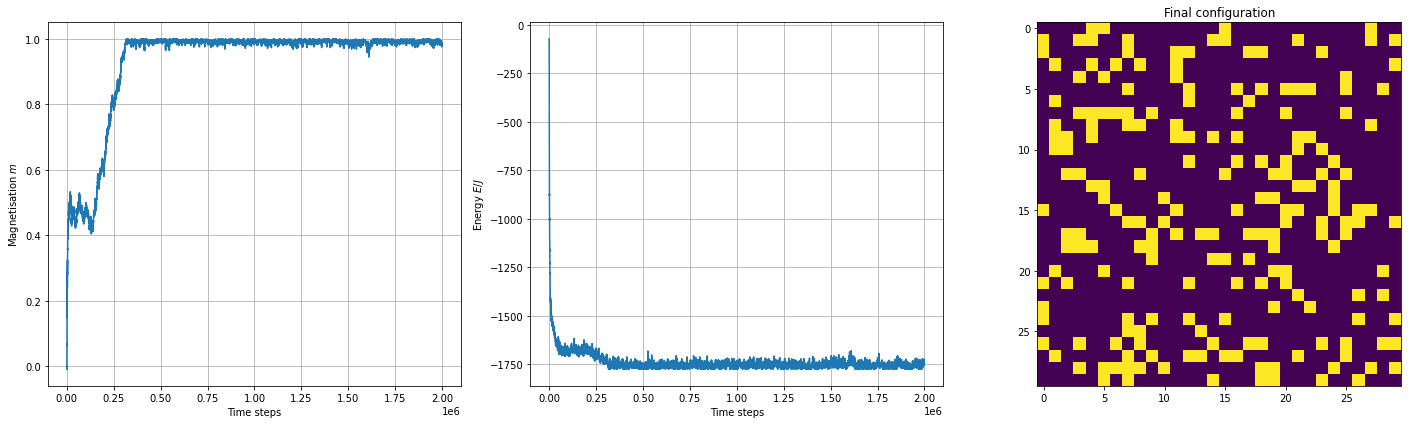

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel("Time steps")
ax.set_ylabel(r"Magnetisation $m$")
ax.grid()

ax = axes[1]
ax.plot(energies)
ax.set_xlabel("Time steps")
ax.set_ylabel(r"Energy $E/J$")
ax.grid()

ax = axes[2]
ax.imshow(lattice_n)
ax.set_title("Final configuration")

fig.tight_layout()

In [10]:
def sample_generation(N, BJ, n_samples, n_iterations, dirPath):

    for i in range(0, n_samples):
        config = create_configuration(N)
        metropolis(config, n_iterations, BJ, total_energy(config))

        if BJ > (1/2.27):
            category = "low"

        else:
            category = "high"

        path = os.path.join(dirPath,category)
        os.makedirs(path, exist_ok=True)
        np.save(os.path.join(path,f"{category}_{BJ:.2f}_{i}_"), config)

### Generating Training Set

In [11]:
BJ_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
train_path = 'mc_data/train'

for i in range(len(BJ_list)):
    sample_generation(30, BJ_list[i], 100, 1000000, train_path)

In [20]:
BJ_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
test_path = 'mc_data/test'

for i in range(len(BJ_list)):
    sample_generation(30, BJ_list[i], 50, 1000000, test_path)

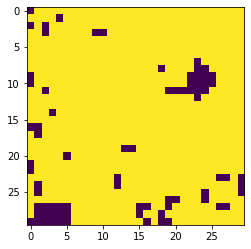

In [19]:
# data_files=os.listdir(f"{train_path}/low")
# sample=np.load(os.path.join(f"{train_path}/low",data_files[5]))
# plt.imshow(sample)